# Analysis of the model parameters estimate III
Here we show the contribution of individual components in the MEM using heatmaps. 

In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylab as pltx
import seaborn as sns
import pystan
import pickle
import scipy.cluster.hierarchy as sch
import copy
import os

# 🔥 Fix: Add utils/ directory where vb_stan.py and sub_fun.py are located
sys.path.append("../utils")  # Ensure utils is in module search path

import vb_stan as vbfun
import sub_fun as sf

# import ./data_file.py file from current directory
try:
    from data_file import *
except ModuleNotFoundError as e:
    print(f"❌ Could not import data_file as module, trying another way...")
    try:
        exec(open('./data_file.py').read())  # Execute the script
    except Exception as e:
        print(f"❌ Could not import data_file.py")


import os

# 1. Read config_mode.txt
config_file = "config_mode.txt"
if os.path.exists(config_file):
    with open(config_file, "r") as f:
        lines = f.read().splitlines()
        data = lines[0].strip() if len(lines) > 0 else "original"
        setting = int(lines[1]) if len(lines) > 1 else 1


# 2. Set plots folder based on config
if data == "original" and setting == 1: 
    figfol = "./plots1/"
elif data == "original" and setting == 2:
    figfol = "./plots2/"
elif data == "new" and setting == 2: 
    figfol = "./plots3/"

if not os.path.exists(figfol):
    os.makedirs(figfol)
    print(f"✅ Created folder: {figfol}")
else:
    print(f"📂 Folder already exists: {figfol}")

if data == "original": 
    data_path = "data_op"
else: 
    data_path = "data_new"
    
# Update plot settings
plt.rcParams.update(plt.rcParamsDefault)
params = {
    'legend.fontsize': 12,
    'font.weight': 'bold',
    'axes.labelsize': 12,
    'axes.titlesize': 12,
    'axes.labelweight': 'bold',
    'xtick.labelsize': 12,
    'figure.dpi': 200,
    'ytick.labelsize': 12
}
plt.rcParams.update(params)

%matplotlib inline


/dss/dsshome1/09/ra64nef3/.conda/envs/vim/lib/python3.7/site-packages/scipy/optimize/_hessian_update_strategy.py:186: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


📂 Folder already exists: ./plots1/


In [2]:
import glob
import pickle
import os


# Define folder path
folname = '../src/'
#fname_best = '18_52_model_nb_cvtest.pkl'
#fname_best = '18_52_model_nb_cvtest.pkl'
fname_best = '30_68_model_nb_cvtest.pkl'
# Load fitted model output
with open(os.path.join(folname, fname_best), 'rb') as f:
    [holdout_mask, llpd, n_test, l, m_seed, sp_mean, sp_var, h_prop, uid, nsample_o, Yte_fit, cv_test] = pickle.load(f)

# Construct filenames using uid and m_seed
fname_ot = os.path.join(folname, f"{uid}_{m_seed}_model_nb.pkl")
#fname_ot = os.path.join(folname, f"{uid}_model_nb.pkl")
sample_fname = os.path.join(folname, f"{uid}_{m_seed}_sample_model_nb_cvtest.pkl")
#sample_fname = os.path.join(folname, f"{uid}_sample_model_nb_cvtest.pkl")
# Load results
with open(fname_ot, 'rb') as f:
    results = pickle.load(f)

# Load sample model output
with open(sample_fname, 'rb') as f:
    [Yte_sample, Yte_cv] = pickle.load(f)


parma_mean  = dict(vbfun.vb_extract_mean(results))

../utils/vb_stan.py:57: RuntimeWarning: invalid value encountered in multiply
  params = OrderedDict([(name, np.nan * np.empty(shape)) for name, shape in param_shapes.items()])


In [ ]:
parma_sample  = vbfun.vb_extract_sample(results)
parma_sample  = dict(parma_sample)
#print(parma_sample)
muest = np.zeros((n,q))
muest1 = np.zeros((n,q))

# Initialize arrays
Yte_lpmf = np.zeros((nsample_o, n, q), dtype=np.float64)
mu_sample = np.zeros((nsample_o, n, q), dtype=np.float64)

# Conditional logic based on config
if data == "original" and setting == 1:
    print("Running OLD DATA DIRECT COUPLING")
    for i in range(n):
        for j in range(q):
            muest[i,j] =  parma_mean['C0'][j] + \
                np.matmul(X[i,],parma_mean['C_geo'][j,:]) + \
                np.matmul(S[i,],np.matmul(parma_mean['A_s'],parma_mean['L_sp'][j,:])) + \
                np.matmul(B[i,],np.matmul(parma_mean['A_b'],parma_mean['L_sp'][j,:]));
                #np.matmul(Q[i,],np.matmul(parma_mean['A_m'],parma_mean['L_sp'][j,:])) + \
            if Yi[i,j] == 1:
                temp = copy.copy(Yi[i,:]);temp[j] = 0;
                muest1[i,j] = np.matmul( parma_mean['L_i'][j,:], np.matmul(parma_mean['L_sp'].T,temp))/(Bs[i]-1.0); 
                muest[i,j] = muest[i,j] + muest1[i,j];
            muest[i,j] =  T_i[i]*np.exp(muest[i,j]* parma_mean['tau'][j])

elif data == "original" and setting == 2:
    print("Running OLD DATA NO DIRECT COUPLING")
    for i in range(n):
        for j in range(q):
            muest[i,j] =  parma_mean['C0'][j] + \
                np.matmul(X[i,],np.matmul(parma_mean['A_geo'],parma_mean['L_sp'][j,:])) + \
                np.matmul(S[i,],np.matmul(parma_mean['A_s'],parma_mean['L_sp'][j,:])) + \
                np.matmul(B[i,],np.matmul(parma_mean['A_b'],parma_mean['L_sp'][j,:]));
                #np.matmul(Q[i,],np.matmul(parma_mean['A_m'],parma_mean['L_sp'][j,:])); 
            if Yi[i,j] == 1:
                temp = copy.copy(Yi[i,:]);temp[j] = 0;
                muest1[i,j] = np.matmul( parma_mean['L_i'][j,:], np.matmul(parma_mean['L_sp'].T,temp))/(Bs[i]-1.0); 
                muest[i,j] = muest[i,j] + muest1[i,j];
            muest[i,j] =  T_i[i]*np.exp(muest[i,j]* parma_mean['tau'][j])
            


elif data == "new" and setting == 2:
    print("Running NEW DATA NO DIRECT COUPLING ")
    for i in range(n):
        for j in range(q):
            muest[i,j] =  parma_mean['C0'][j] + \
                np.matmul(X[i,],np.matmul(parma_mean['A_geo'],parma_mean['L_sp'][j,:])) + \
                np.matmul(S[i,],np.matmul(parma_mean['A_s'],parma_mean['L_sp'][j,:])) + \
                np.matmul(D[i,],np.matmul(parma_mean['A_d'],parma_mean['L_sp'][j,:])) + \
                np.matmul(B[i,],np.matmul(parma_mean['A_b'],parma_mean['L_sp'][j,:]));
                #np.matmul(Q[i,],np.matmul(parma_mean['A_m'],parma_mean['L_sp'][j,:])) + \
            if Yi[i,j] == 1:
                temp = copy.copy(Yi[i,:]);temp[j] = 0;
                muest1[i,j] = np.matmul( parma_mean['L_i'][j,:], np.matmul(parma_mean['L_sp'].T,temp))/(Bs[i]-1.0); 
                muest[i,j] = muest[i,j] + muest1[i,j];
            muest[i,j] =  T_i[i]*np.exp(muest[i,j]* parma_mean['tau'][j])

elif data == "new" and setting == 1:
    print("Running NEW DATA NO DIRECT COUPLING ")
    for i in range(n):
        for j in range(q):
            muest[i,j] =  parma_mean['C0'][j] + \
                np.matmul(X[i,],parma_mean['C_geo'][j,:]) + \
                np.matmul(S[i,],np.matmul(parma_mean['A_s'],parma_mean['L_sp'][j,:])) + \
                np.matmul(D[i,],np.matmul(parma_mean['A_d'],parma_mean['L_sp'][j,:])) + \
                np.matmul(B[i,],np.matmul(parma_mean['A_b'],parma_mean['L_sp'][j,:]));
                #np.matmul(Q[i,],np.matmul(parma_mean['A_m'],parma_mean['L_sp'][j,:])) + \
            if Yi[i,j] == 1:
                temp = copy.copy(Yi[i,:]);temp[j] = 0;
                muest1[i,j] = np.matmul( parma_mean['L_i'][j,:], np.matmul(parma_mean['L_sp'].T,temp))/(Bs[i]-1.0); 
                muest[i,j] = muest[i,j] + muest1[i,j];
            muest[i,j] =  T_i[i]*np.exp(muest[i,j]* parma_mean['tau'][j])
            


else:
    raise ValueError(f"Combination data={data} and setting={setting} not supported yet.")



../utils/vb_stan.py:25: RuntimeWarning: invalid value encountered in multiply
  params = OrderedDict([(name, np.nan * np.empty((n, ) + tuple(shape))) for name, shape in param_shapes.items()])


Running OLD DATA DIRECT COUPLING


In [4]:
import pandas as pd
import numpy as np

# Load species taxonomy data
tax_name = pd.read_csv(f'../data/{data_path}/species_tax.csv')
tax_name = tax_name.rename(columns={'Unnamed: 0': 'OTU'})
tax_name = tax_name[1:]  # Remove first row if needed
tax_name.insert(0, 'Id', tax_name['OTU'].str[3:])
tax_name.columns.values[1] = 'Label'
tax_name.to_csv('node_otu.csv', index=False)

# Process taxonomy levels
temx = tax_name.iloc[:, :8].replace(np.nan, '')
species_name = []

# Add taxonomy identifier for species names
for i in range(temx.shape[0]):
    a = temx.iloc[i, :].values
    for j in range(len(a)-1, -1, -1):
        if len(a[j]) > 0:
            species_name.append(temx.columns[j][0].lower() + '_' + a[j])
            break

species_name = np.array(species_name)
tax_name['Name'] = species_name

# Compute abundance for each species
tax_name['Abundance'] = Y.sum(axis=0)
tax_name[['Id']] = tax_name[['Id']].values.astype(np.int64)
tax_name = tax_name.replace(np.nan, 'Empty')

# Load additional annotations
tem = pd.read_csv(f'../data/{data_path}/species_tax_anot.amended.csv').iloc[:, [1, 12]]
tax_name = tax_name.merge(tem, on='Label')
tax_name = tax_name.rename(columns={"Ecologically_relevant_classification_aggregated": "ECR"})

# **Clustering Based on ECR Instead of ERC_community.pkl**
ecr_categories = tax_name['ECR'].unique()
ecr_mapping = {category: i+1 for i, category in enumerate(ecr_categories)}

# Assign cluster index based on ECR categories
tax_name['COMIND'] = tax_name['ECR'].map(ecr_mapping)

# Assign colors based on clusters (Dynamic color mapping)
color_list = ['red', 'blue', 'green', 'yellow', 'grey', 'purple', 'orange', 'pink']
clust_col = np.array([color_list[i % len(color_list)] for i in tax_name['COMIND'] - 1])
tax_name['Cluster'] = clust_col

# **Sorting based on cluster indices**
tax_nameN = tax_name[['Label', 'ECR', 'COMIND', 'Cluster']].copy()
tax_nameN['val'] = c_ord  # Assuming `c_ord` exists
tax_nameN.loc[tax_nameN.index[c_ord], 'val'] = range(Y.shape[1])# Fix ordering
tax_nameN = tax_nameN.sort_values(["COMIND", "val"], ascending=(True, False))

# **Create cluster indices for visualization**
v_indexN = [0] + list(np.where(np.diff(tax_nameN.COMIND.values) > 0)[0]) + [Y.shape[1]]
c_ordN = np.array(tax_nameN.index)

# ✅ **No more dependency on ERC_community.pkl**


In [5]:
print("X shape:", X.shape)
print("A_geo shape:", parma_mean["A_geo"].shape)
print("c_ordN:", c_ordN)

X shape: (139, 9)


KeyError: 'A_geo'

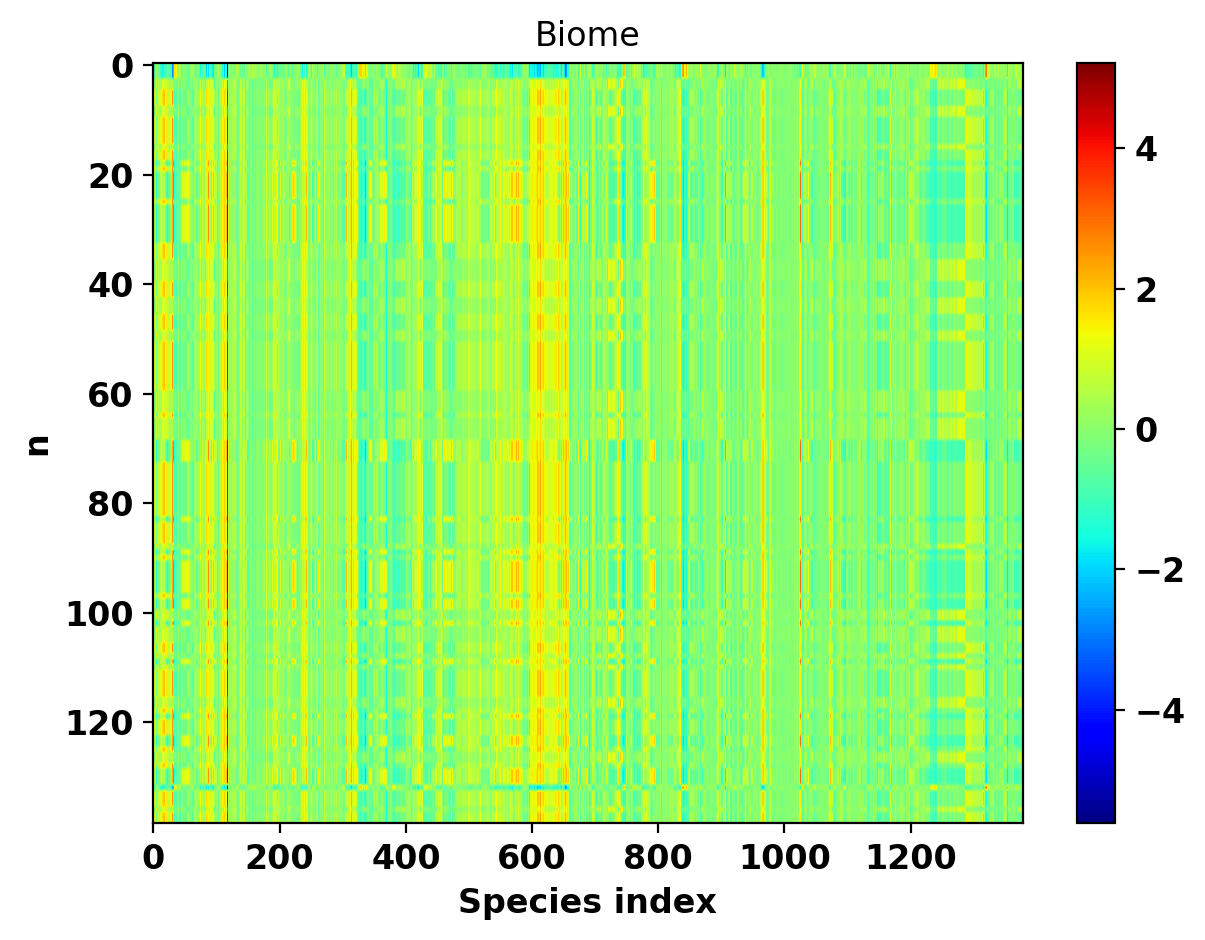

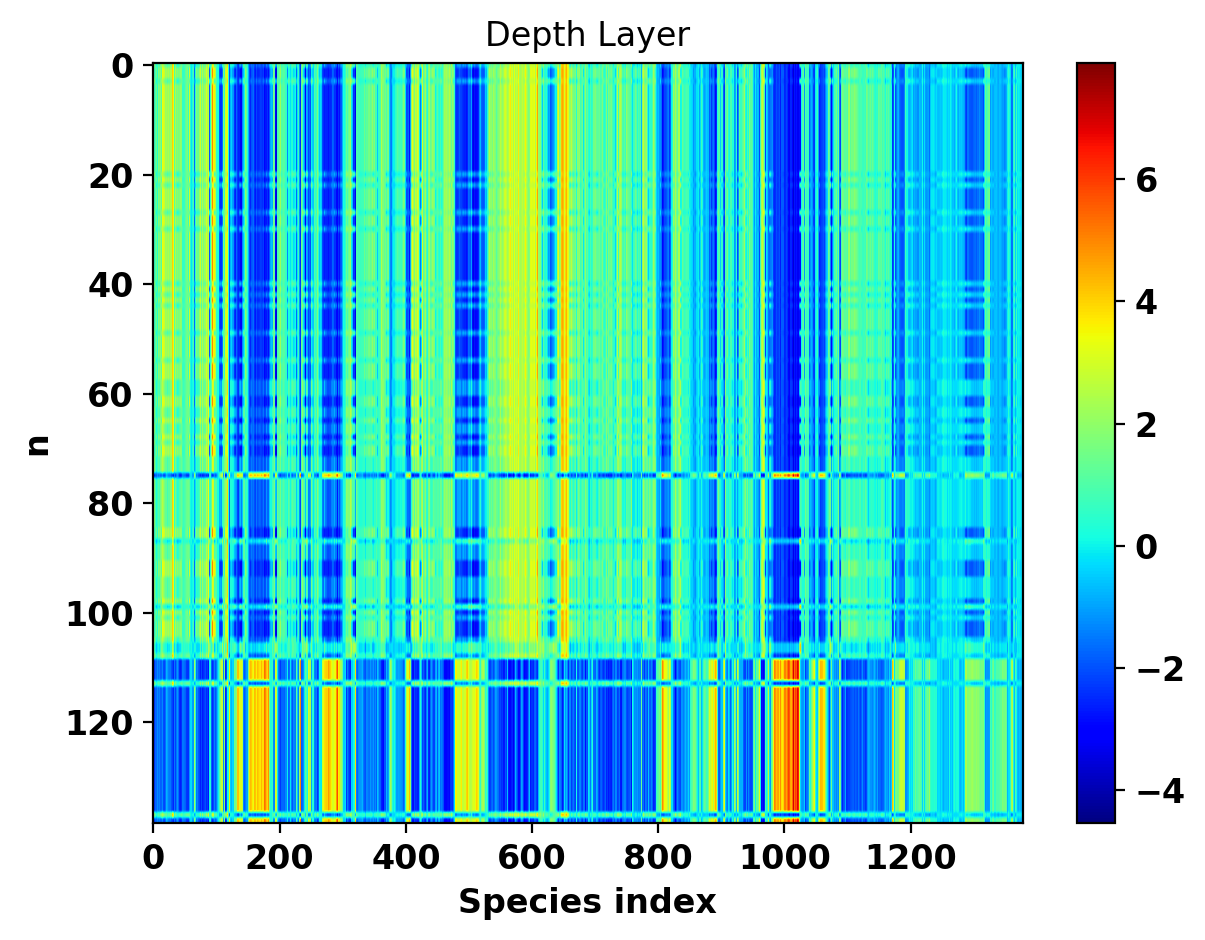

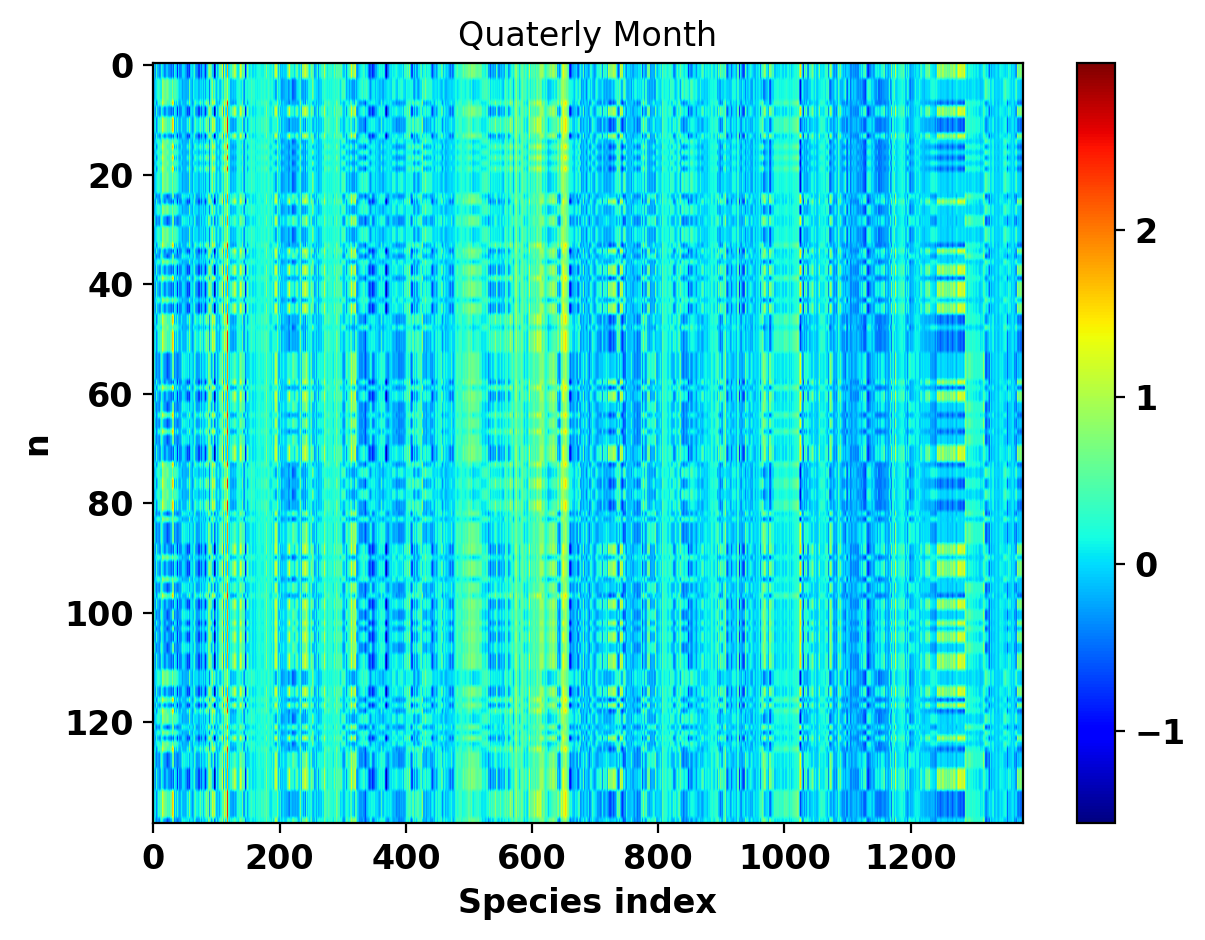

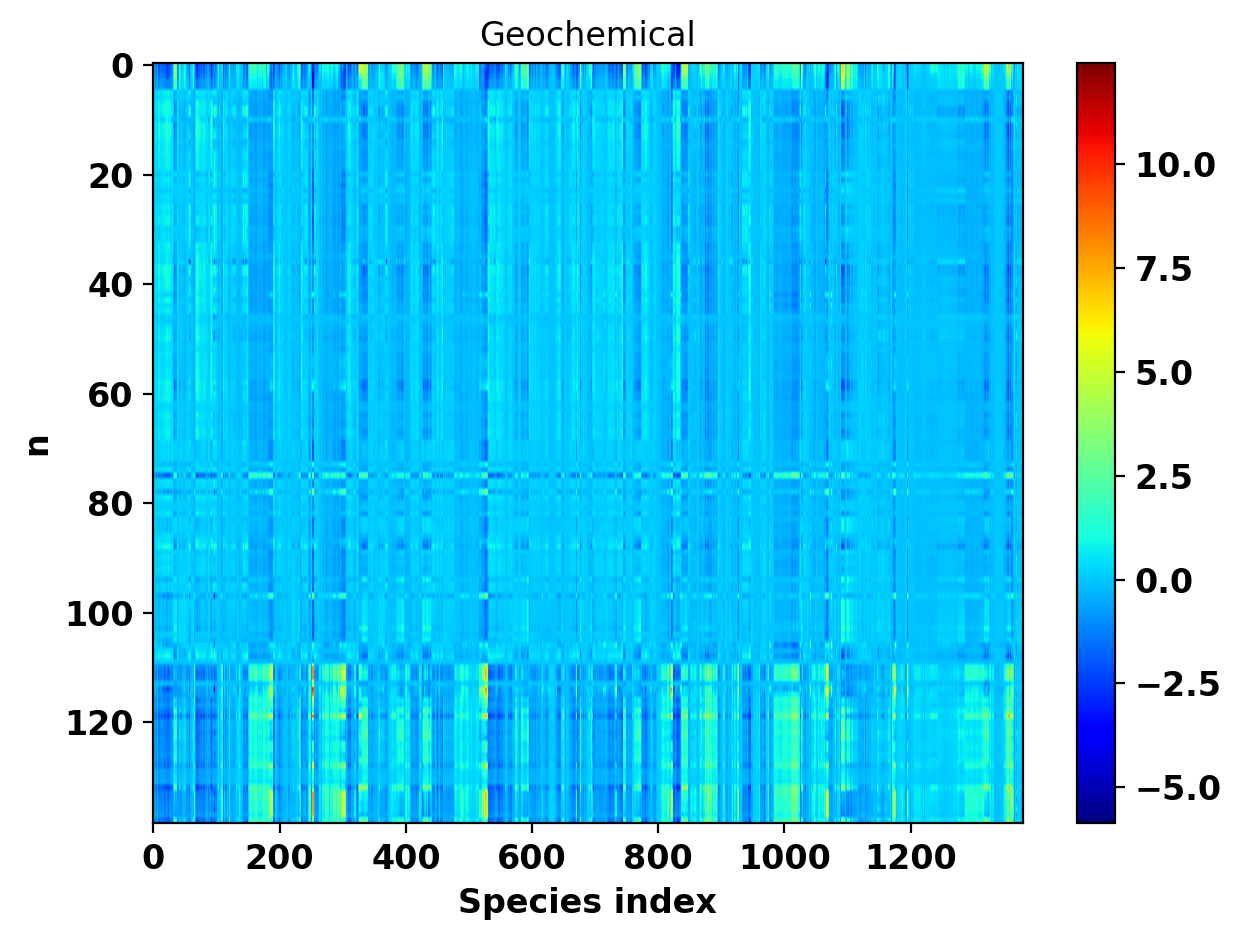

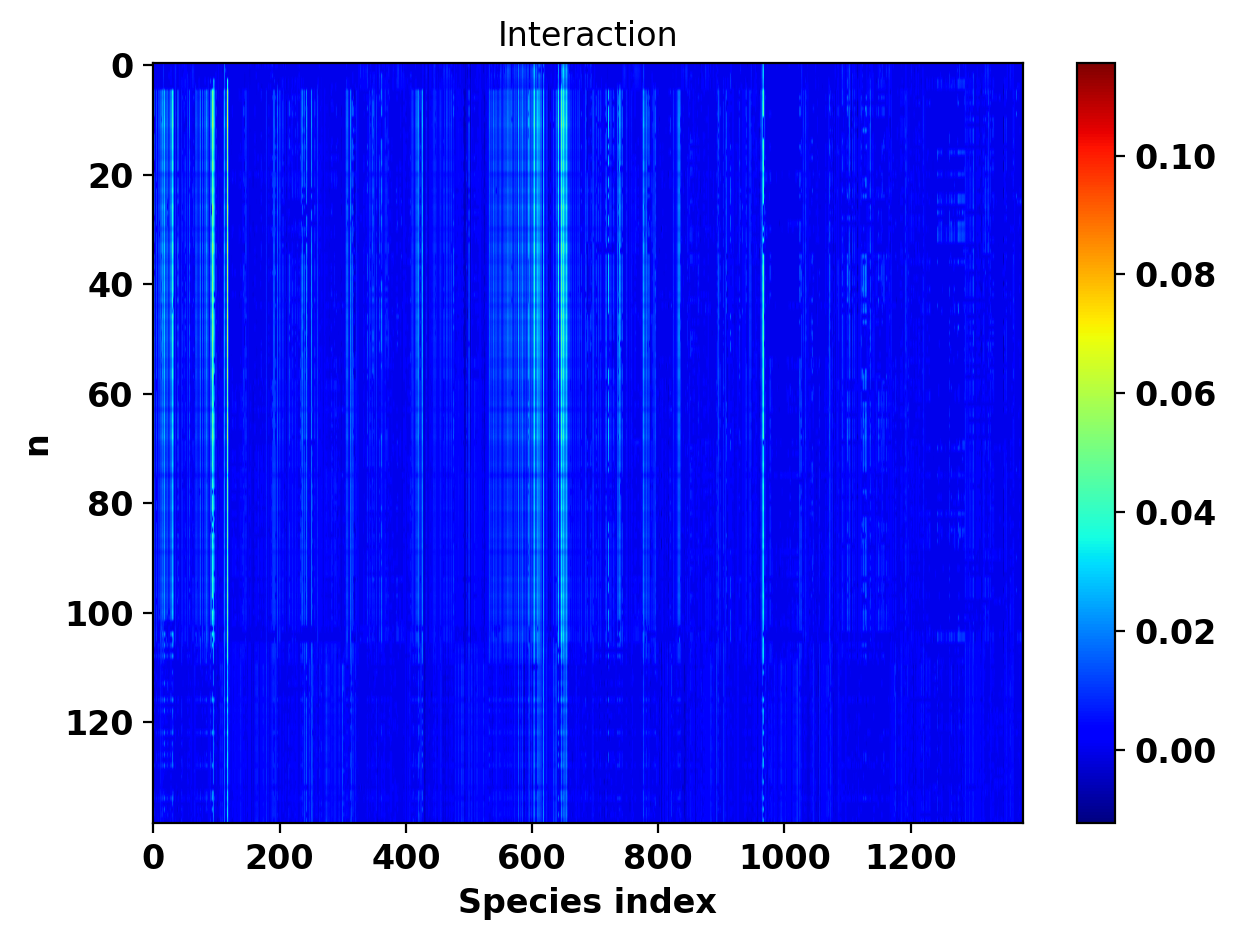

In [7]:
## Contributions of the components of the model 
from matplotlib.backends.backend_pdf import PdfPages
fnamex = figfol + 'fixed_effect.pdf'
pp = PdfPages(fnamex)
col_ulim = np.log((Y+1).max())

## Region effect: contribution of the spatio temporal locations in the ocean 
tem = np.matmul(S,np.matmul(parma_mean['A_s'],\
                            parma_mean['L_sp'].transpose()))
tem = tem[r_ord][:,c_ordN]
fig, ax = plt.subplots()
im = ax.imshow(tem,cmap='jet', aspect='auto')
ax.set_xlabel('Species index')
ax.set_ylabel('n')
ax.set_title('Biome')
fig.colorbar(im)
fig.tight_layout()
pp.savefig(fig, dpi = 200)



## Biome effect: contribution of the Biome/depth 
tem = np.matmul(B,np.matmul(parma_mean['A_b'],\
                            parma_mean['L_sp'].transpose()))
tem = tem[r_ord][:,c_ordN]
fig, ax = plt.subplots()
im = ax.imshow(tem,cmap='jet', aspect='auto')
ax.set_xlabel('Species index')
ax.set_ylabel('n')
ax.set_title('Depth Layer')
fig.colorbar(im)
fig.tight_layout()
pp.savefig(fig, dpi = 200)


## Quarter effect: contribution of the time of the data collection 
tem = np.matmul(Q,np.matmul(parma_mean['A_m'],\
                            parma_mean['L_sp'].transpose()))
tem = tem[r_ord][:,c_ordN]
fig, ax = plt.subplots()
im = ax.imshow(tem,cmap='jet', aspect='auto')
ax.set_xlabel('Species index')
ax.set_ylabel('n')
ax.set_title('Quaterly Month')
fig.colorbar(im)
fig.tight_layout()
pp.savefig(fig, dpi = 200)

#A_geo = parma_mean['A_geo'].transpose()
## Geochemical component effect: contribution of the geochemical covariates 
if data == "original" and setting == 1: 
    tem = np.matmul(X,parma_mean["C_geo"].transpose())
    tem = tem[r_ord][:,c_ordN]
    fig, ax = plt.subplots()
    im = ax.imshow(tem,cmap='jet', aspect='auto')
    ax.set_xlabel('Species index')
    ax.set_ylabel('n')
    ax.set_title('Geochemical')
    fig.colorbar(im)
    fig.tight_layout()
    pp.savefig(fig, dpi = 200)
elif data == "original" and setting == 2:
    tem = np.matmul(X, np.matmul(parma_mean["A_geo"], parma_mean["L_sp"].T))  # (139, 1300)
    tem = tem[r_ord][:,c_ordN]
    fig, ax = plt.subplots()
    im = ax.imshow(tem, cmap='jet', aspect='auto')
    ax.set_xlabel('Species index')
    ax.set_ylabel('n')
    ax.set_title('Geochemical')
    fig.colorbar(im)
    fig.tight_layout()
    pp.savefig(fig, dpi=200)

## Interaction component effect: contribution of the species-species interaction term 
tem = muest1;
tem = tem[r_ord][:,c_ordN]
fig, ax = plt.subplots()
im = ax.imshow(tem,cmap='jet', aspect='auto')
ax.set_xlabel('Species index')
ax.set_ylabel('n')
ax.set_title('Interaction')
fig.colorbar(im)
fig.tight_layout()
pp.savefig(fig, dpi = 200)


pp.close()